In [1]:
# Co-Register WV3 image to MSI data using AROSICS https://danschef.git-pages.gfz-potsdam.de/arosics/doc/usage/global_coreg.html
# AND export after applying Sentinel 2 MSI point spread functions for equivalent bands
# 
# inputs
#

# select global or local coregistration
COREGTYPE = "global"

# specify WV3 product path and subproduct index 
WV3asset = "users/hemitshah/NEON/WV3CanadaCCRS" # Collection of WV3 tiles in GEE used to specify bounds of MSI data to subset
WV3id = "wv3_20170612_N5310W06629" # The WV3 image ID, corresponds to "TITLEPrope" property of WV3 asset
WV3path = "C:\\Users\\rfern\\downscaling\\010543783100_01\\" # Local path of WV3 product , we only use the MS data, it can have multiple images
WV3datafolder = "010543783100_01_P002_MUL\\"  # Name of folder where the WV3 bands we will use lies 
WV3product  = "17JUN12154136-M2AS-010543783100_01_P002"  # Name of The WV3 image within the product
WV3band = 3 # the band we hope matches the MSIBand (1=red, 2=blue, 3=green, 4=NIR)
WV3filename = WV3path+WV3datafolder+WV3product  # constructed full file name except for suffix 

# specify the Sentinel 2 MSI Product in Google Earth Engine we will use as reference for co-registration
MSIasset = "COPERNICUS/S2/"  # L1C GEE collection
MSIid = "20170612T153911_20170612T153906_T19UFU" # Should have cloud free overlap with WV3 image. 0=no data
MSIband = "B3" # the band we will use for coregistration
resample = 5 # resampling factor applied to MSI data prior to registration
Gdrive_cloud = "ExportedData" # The google drive on the cloud that is synced to local workstation
Gdrive = "C:\\Users\\rfern\\GoogleDriveHemit\\ExportedData" # The google drive on local workstation synced to Grdive_cloud
MSIfilename = Gdrive+"\\"+WV3id+"_"+MSIid # constructed full file name except for suffix 

# output 
# WV3filename+"_"+COREGTYPE+".tif"  - spatially transformed version of WV3filename
# WV3filename+"_"+COREGTYPE+"_msi.tif"  - spatially transformed and filtered version of WV3filename
# WV3filename+"_"+COREGTYPE+".txt" - average shifts 
# WV3filename+"_"+COREGTYPE+".csv" - local shifts (for COREGTYPE=local only)

In [2]:
%config IPCompleter.greedy=True

In [27]:
import cv2
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio import plot
from rasterio.enums import Resampling
from matplotlib import pyplot as p  
from geoarray import GeoArray
from arosics import COREG
from arosics import COREG_LOCAL
from arosics import DESHIFTER
from scipy.ndimage import gaussian_filter
from PIL import Image
import geopandas as gpd
import ee
import logging

In [37]:
# get access to GEE account that has WV3asset 
ee.Authenticate()

Enter verification code:  4/1AY0e-g7FWFyj5lcABr402YDa8LcJ-uNJmKW0iooLNtMwlKlh5WFwI8jz_jQ



Successfully saved authorization token.


In [38]:
# start GEE
ee.Initialize()

In [6]:
# logging setup
logging.basicConfig(filename='WV3registration.log', level=logging.WARNING)

In [7]:
# in memory raster resampler function
# Example licensed under cc by-sa 3.0 with attribution required
from contextlib import contextmanager  
import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, scale=5):
    t = raster.transform

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = raster.height * scale
    width = raster.width * scale

    profile = src.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.bilinear,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


In [8]:
# to disk raster resampler function
# Example licensed under cc by-sa 3.0 with attribution required
from contextlib import contextmanager  
import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_rasterdisk(raster, filename,  scale=5):
    t = raster.transform

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = raster.height * scale
    width = raster.width * scale

    profile = src.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.bilinear,
        )

    with rasterio.open(filename, 'w', **profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data
    return  

In [43]:
# export selected MSI band subset overlapping requested WV3 asset feature to drive and hold until task is done
task = ee.batch.Export.image.toDrive(
              image= ee.Image(MSIasset+MSIid).select([MSIband]),
              description= (WV3id+"_"+MSIid),
              folder= Gdrive_cloud,
              fileNamePrefix= (WV3id+"_"+MSIid),
              scale= 10,
              region= (ee.Feature(ee.FeatureCollection(WV3asset).filterMetadata("TITLEPrope","equals",WV3id).first())).geometry().getInfo()['coordinates']
            );
                
task.start()
taskstat = task.status()['state']
print(taskstat)
while taskstat == 'READY' or taskstat == 'RUNNING':
    taskstat = task.status()['state']
print(task.status())

READY
{'state': 'COMPLETED', 'description': 'wv3_20170612_N5310W06629_20170612T153911_20170612T153906_T19UFU', 'creation_timestamp_ms': 1611942502065, 'update_timestamp_ms': 1611942642584, 'start_timestamp_ms': 1611942538199, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1twT3VJEEWLYtJT-odTIl750Wvs6a8tXF'], 'attempt': 1, 'id': 'MXZEZKRT2AEE5UUUOFLVRJRV', 'name': 'projects/earthengine-legacy/operations/MXZEZKRT2AEE5UUUOFLVRJRV'}


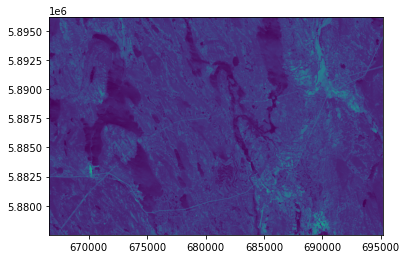

CRS.from_epsg(32619)

In [9]:
# check MSIimage on  local drive (optional) - it may be bigger than the WV3 image as WV3 products have multiple images in footprint
MSItest = rasterio.open(MSIfilename+".tif",nodata=0)
plot.show(MSItest) 
MSItest.crs

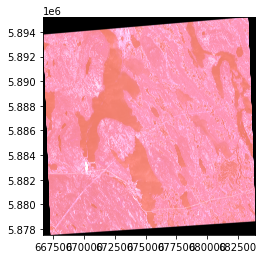

CRS.from_epsg(26919)

In [10]:
# check WV3 image on  local drive (optional)
WV3 = rasterio.open(WV3filename+".tif")
plot.show(WV3) 
WV3.crs

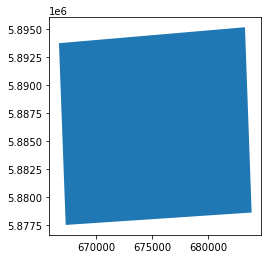

In [11]:
# get WV3 boundary polygon and add the projection info
WV3poly=gpd.read_file(WV3path + "GIS_FILES\\" + WV3product + "_PIXEL_SHAPE.shp")
WV3poly = WV3poly.to_crs(WV3.crs)
WV3poly.head()
WV3poly.plot()
WV3poly.crs
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [12]:
# subset and upsample the MSI image we will use for registration , the resampled image will be saved on the local google drive
with rasterio.open(MSIfilename+".tif",nodata=0) as MSI:
    MSI_img, MSI_transform = rasterio.mask.mask(MSI, getFeatures(WV3poly), crop=True)
    profile = MSI.profile    
    profile.update({"driver": "GTiff",
                     "height": MSI_img.shape[1],
                     "width": MSI_img.shape[2],
                     "transform": MSI_transform,
                     "crs": WV3poly.crs ,
                      "nodata":0 }
                       ) 
    with MemoryFile() as memfile:
        with memfile.open(**profile) as src: # Open as DatasetWriter
            src.write(MSI_img)
            del MSI_img          
            resample_rasterdisk(src,MSIfilename+"_"+str(resample)+".tif",resample) 

In [51]:
# register the WV3 image to the resampled MSI image using specified band 
geoArr  = GeoArray(MSIfilename+"_"+str(resample)+".tif")
ref_ndarray = geoArr[:]
ref_gt      = geoArr.geotransform
ref_prj     = geoArr.projection 
reference = GeoArray(ref_ndarray, ref_gt, ref_prj)

geoArr  = GeoArray( WV3filename+".tif") 
tar_ndarray = geoArr[:]
tar_gt      = geoArr.geotransform
tar_prj     = geoArr.projection 
target = GeoArray(tar_ndarray, tar_gt, tar_prj)
# global registration
if COREGTYPE == "local":
    #local registration 
    CR = COREG_LOCAL(reference, target, grid_res = 200, window_size = (256,256),  r_b4match= WV3band, s_b4match=1,  align_grids=1, nodata=(0,0),path_out=WV3filename+"_"+COREGTYPE+"".tif",fmt_out="GTIFF")
    CR.calculate_spatial_shifts()
    CR.view_CoRegPoints(figsize=(15,15), backgroundIm='ref')
    CR.CoRegPoints_table
    CR.CoRegPoints_table.to_csv(r(WV3filename+"_"+COREGTYPE+".csv"))
else:
    CR = COREG(reference, target, ws = (256,256), align_grids=1,  r_b4match= 1, s_b4match=4,   nodata=(0,0),path_out=WV3filename+"_"+COREGTYPE+.tif",fmt_out="GTIFF")
    CR.calculate_spatial_shifts()
CoRegShiftFile = open(WV3filename+"_"+COREGTYPE+".txt","w")
CoRegShiftFile.write(CR.calculate_spatial_shifts())



Calculating actual data corner coordinates for reference image...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:01


Bounding box of calculated footprint for reference image:
	(666680.0, 5877526.0, 683890.0, 5895184.0)
Calculating actual data corner coordinates for image to be shifted...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:01


Bounding box of calculated footprint for image to be shifted:
	(666678.0, 5877526.0, 683892.0, 5895182.0)
Matching window position (X,Y): 675313.0862952274/5886277.581200351


Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.44398382911958745/0.37622897328840965
Calculated total shifts in fft pixel units (X/Y):         0.44398382911958745/0.37622897328840965
Calculated total shifts in reference pixel units (X/Y):   0.44398382911958745/0.37622897328840965
Calculated total shifts in target pixel units (X/Y):      0.44398382911958745/0.37622897328840965
Calculated map shifts (X,Y):				  0.8879676582291722/-0.7524579465389252
Calculated absolute shift vector length in map units:     1.1639070080425566
Calculated angle of shift vector in degrees from North:   310.27772174839043
Original map info: ['UTM', 1.0, 1.0, 666672.0, 5895184.0, 2.0, 2.0, 19, 'North', 'NAD83']
Updated map info:  ['UTM', 1.0, 1.0, '666672.8879676582', '5895183.247542053', 2.0, 2.0, 19, 'North', 'NAD83']
Image similarity within the matching window (SSIM before/after correction): 0.3772 => 0.4504
Estimated reliability of 

Warping progress     |==================================================| 100.0% Complete  => 0:00:21


In [57]:
im2 = DESHIFTER(target, CR.coreg_info,path_out=WV3filename+"_"+COREGTYPE+"*.tif",fmt_out="GTIFF").correct_shifts()

Warping progress     |=-------------------------------------------------| 1.0% Complete  => 0:00:00

Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:21


Writing GeoArray of size (8829, 8620, 8) to C:\Users\rfern\downscaling\010543783100_01\010543783100_01_P002_MUL\17JUN12154136-M2AS-010543783100_01_P002_global.tif.


In [58]:
# apply msi psf to wv3 VNIR image
# we assume the WV3 bands and corresponding MSI MTFs are as below
# WV3 band          MSI MTF stdev
# 1 = coastal       0.0173
# 2 = blue          0.0318
# 3 = green         0.0313
# 4 = yellow        0.0313
# 5 = red           0.0305
# 6 = red edge      0.0173
# 7 = nir1          0.0163
# 8 = nri2          0.0292
# The MSI MTFs are taken from Li et al. https://www.mdpi.com/2072-4292/12/15/2406/htm
sigmaf = np.array([0.0173,0.0318,0.0313,0.0313,0.0305,0.0173,0.0163,0.0292])
sigmal =  1/(sigmaf*2*3.14159256)
print(sigmal)
for x in range(1,8):
  im2['arr_shifted'][:,:,x] =  gaussian_filter( np.array(im2['arr_shifted'][:,:,x],dtype=np.uint16),sigma=sigmal[x])
im2['GeoArray_shifted'].save(out_path=path_out=WV3filename+"_"+COREGTYPE+"*.tif",fmt="GTIFF")

OrderedDict([('band', None), ('is shifted', True), ('is resampled', True), ('updated map info', ['UTM', 1.0, 1.0, 666672.0, 5895184.0, 2.0, 2.0, 19, 'North', 'NAD83']), ('updated geotransform', (666672.0, 2.0, 0.0, 5895184.0, 0.0, -2.0)), ('updated projection', 'PROJCS["NAD83 / UTM zone 19N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26919"]]'), ('arr_shifted', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],